### Objectives of the notebook
* Run, save the version and download the trained model for various time window sizes mentioned below
    * 100ms, 200ms, 300ms, 400ms, 500ms, 600ms, 700ms, 800ms, 900ms
* Document the confusion matrices, classwise accuracies and training graphs of all the above models in a google document.

* Repeat the below mentioned instructions for all the time-window sizes

### Instructions to run and save the version of this notebook

* Move to the first code cell under "Scratch Training on Default Preprocessed Data" section below, and replace the value of "samples" variable according to the calculation mentioned in the comments section by plugging in "n" milli seconds, where n is a milli second in the given list above

* Now go to the next code block below and change the value of "twms" to the nth milli second that is taken

* Now click on "Run all" from the "run" option on the navigation bar of kaggle

* After the notebook has run and after documenting the results, click on save version and name the version in the format as "SleepVNirodha:EEGNet-DefaultPreprocessed-nms" here in place of "nms" replace "nth milli second value" + "ms". Eg : 1000ms, 200ms etc. Also ensure that while saving version you click on "quick save" in the drop down menu.

* Now from the "/kaggle/working" directory in the Output section, locate the downloaded model zip file and place it in the research google drive under "SleepVNirodha Models/DefaultPreprocessed" directory.  


##### PS : An example version (in kaggle), trained model (in drive), and results (in drive) can be found for your reference

In [1]:
!pip install gdown

In [2]:
!pip install pyedflib
!pip install pyriemann
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyriemann: filename=pyriemann-0.4-py2.py3-none-any.whl size=105114 sha256=0336c942fd68d07f2a26f608d5ac4208bb26597a94f2e4954dca0584dc69135b
  Stored in directory: /root/.cache/pip/wheels/7d/56/e9/c8593cf3c4b4c5cea6cd0cad43f9332c4cfe2e5769a5e663ad
Successfully built pyriemann


In [3]:
!pip install pymatreader

# **Import required libraries and classes**

In [4]:
import sys
sys.path.append('/kaggle/input/myeegmodules')
from eegnet_logics import *

**To Download PreProcessed Data**

In [5]:
!gdown 1fJGVMQTxZynmbvr4IxSX02_yL60sSvnH
!gdown 1kcKDjJ7kwhGlXLG80s9qxCSpOeXApIYa
!gdown 1J19wA9Q0ZBdBLjG3n9RDHWEiPPmbSiBv
!gdown 1rJlOAuyG5QR-jA4b43tnye3uG_gVrwTw

Downloading...
From (uriginal): https://drive.google.com/uc?id=1fJGVMQTxZynmbvr4IxSX02_yL60sSvnH
From (redirected): https://drive.google.com/uc?id=1fJGVMQTxZynmbvr4IxSX02_yL60sSvnH&confirm=t&uuid=d87052a2-4622-499e-9983-310a8cb2376e
To: /kaggle/working/SUB200921 - 20210920T132431.set
100%|█████████████████████████████████████████| 904M/904M [00:08<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kcKDjJ7kwhGlXLG80s9qxCSpOeXApIYa
To: /kaggle/working/SUB200921-2 - 20210920T164137.set
100%|██████████████████████████████████████| 53.8M/53.8M [00:00<00:00, 57.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1J19wA9Q0ZBdBLjG3n9RDHWEiPPmbSiBv
To: /kaggle/working/SUB200921-3 - 20210920T165003.set
100%|██████████████████████████████████████| 83.5M/83.5M [00:00<00:00, 93.3MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1rJlOAuyG5QR-jA4b43tnye3uG_gVrwTw
From (redirected): https://drive.google.com/uc?id=1rJlOAuyG5QR-jA4b43tnye3uG_gVrwTw&confirm=t&u

# **EEGNet Model**


```
def EEGNet_tensorflow(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    """
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################(Chans, Samples, 1)
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)
```



## **Scratch Training on Default PreProcessed Data**

In [6]:
import os
data_sampling_rate = 512
chans, samples, kernels = 64, 512, 1  #(n in milli seconds/1000)*512
data_paths =  ['/kaggle/working/SUB200921-3 - 20210920T165003.set', '/kaggle/working/SUB200921-4 - 20210920T170117.set', '/kaggle/working/SUB200921 - 20210920T132431.set','/kaggle/working/SUB200921-2 - 20210920T164137.set']
data_paths = [data_paths[2], data_paths[3], data_paths[0], data_paths[1]] #full nap, awake at rest, awake and talking, meditating
data_paths_only_2 = [data_paths[0], data_paths[3]]

dataset_creator = EEGAsDatasetCreator(dataset_dir='/kaggle/working/sleepvnirodha', limit_data_seconds=7200,data_resample=512, channels=chans,data_time_steps=samples, data_paths=data_paths_only_2, train_split_per_recording=0.8, shuffle_before_record_split=False, scale=1e9)
train_dataset_generator = dataset_creator('/kaggle/working/sleepvnirodha/train', batch_size=256)
test_dataset_generator = dataset_creator('/kaggle/working/sleepvnirodha/test', batch_size=128)

train_samples, test_samples = len(os.listdir('/kaggle/working/sleepvnirodha/train')), len(os.listdir('/kaggle/working/sleepvnirodha/test'))
print("Total Train samples : ", train_samples)
print("Total Test samples : ", test_samples)

/opt/conda/lib/python3.7/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/kaggle/input/myeegmodules/eegnet_logics.py:495: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(f'{path}') # mne.io.read_raw_bdf(f'{path}', infer_types=True)
/opt/conda/lib/python3.7/site-packages/pymatreader/utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/kaggle/input/myeegmodules/eegnet_logics.py:495: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(f'

Total Train samples :  11017
Total Test samples :  2755


In [7]:
from math import ceil
train_steps = ceil(train_samples/256)
test_steps = ceil(test_samples/128)
generator_info = {'train_generator' : train_dataset_generator, 'test_generator' : test_dataset_generator, 'steps_per_train_epoch': train_steps, 'steps_per_test_epoch' : test_steps}

In [8]:
print(next(train_dataset_generator))

(array([[[-2.74378966e+03, -2.57498814e+03, -2.65663313e+03, ...,
          6.06304787e+03,  7.44808961e+03,  8.38443803e+03],
        [ 8.79541923e+03,  8.70815610e+03,  8.18105556e+03, ...,
         -1.82760788e+03, -1.44677006e+03, -1.29733862e+03],
        [-1.34690200e+03, -1.49396647e+03, -1.62924980e+03, ...,
         -1.79034270e+03, -3.21564936e+03, -4.67372180e+03],
        ...,
        [ 9.37635184e+03,  8.66910695e+03,  8.24481727e+03, ...,
          4.12985276e+03,  4.00409461e+03,  3.58564400e+03],
        [ 2.97271491e+03,  2.37603783e+03,  2.00805689e+03, ...,
          3.76754402e+03,  2.45013453e+03,  1.10041593e+03],
        [-1.06124256e+02, -9.89625048e+02, -1.45029901e+03, ...,
          1.63545461e+04,  1.51090398e+04,  1.35121045e+04]],

       [[ 1.77339520e+03,  1.77482866e+03,  1.73300518e+03, ...,
         -4.04439940e+03, -3.42913710e+03, -2.81715526e+03],
        [-2.34134851e+03, -2.08273210e+03, -2.05340587e+03, ...,
         -1.89129700e+03,  3.39799322

====================Model Architecture====================
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 512, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 512, 8)        2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 512, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 512, 16)        1024      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 512, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 512, 16)        0         
_________________________________________________________________
av

'/kaggle/working/EEGNet-DefaultPreprocessed-SleepVNirodha-TW1000ms-Model.zip'

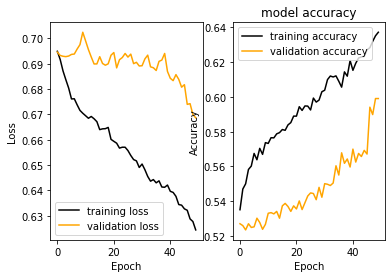

In [9]:
tf.random.set_seed(6)
prmodel = EEGNet_tensorflow(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.25, kernLength = data_sampling_rate//2, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')
trainer = TrainingSleepVNirodha(model=prmodel, channels=chans, sever_model_top=False, out_classes=None)    
finetuned_model = trainer(epochs=50, batch_size=1024, progressive_data_load=True, generator_info=generator_info, lr=1e-3)
twms = 1000 #insert the nth milli second value here
model_name = f'EEGNet-DefaultPreprocessed-SleepVNirodha-TW{twms}ms'
trainer.model.save(f'./{model_name}')

from IPython.display import FileLink
import shutil
shutil.make_archive(f'{model_name}-Model', 'zip', f'./{model_name}')

#print("Per sample Accuracy")
#trainer.get_stats(mode='per_sample_acc')
#print("Classwise Per sample accuracy")
#trainer.get_stats(mode='per_class_acc')
#print("Recordwise Per sample Accuracy")
#trainer.get_stats(mode='per_rec_acc')
#print("Recordwise Votings")
#trainer.get_stats(mode='per_rec_vot')


In [10]:
Ypreds, Y = [], []
for batch in range(test_steps):
    x, y = next(test_dataset_generator)
    ypred = np.argmax(trainer.model.predict(x), axis=-1)
    Ypreds.append(ypred)
    Y.append(y)

Ypreds = np.concatenate(Ypreds, axis=0)
Y = np.concatenate(Y, axis=0)
Ypreds.shape, Y.shape

((2816,), (2816,))

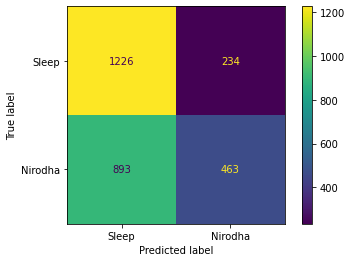

Sleep Accuracy : 83.97260273972603%
Nirodha Accuracy : 34.14454277286136%
Overall Accuracy : 59.97869318181818%


In [11]:
from sklearn import metrics

actual = Y
predicted = Ypreds

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Sleep", "Nirodha"])

cm_display.plot()
plt.show()

class_samples_counts = np.sum(confusion_matrix, axis=1)
print(f"Sleep Accuracy : {(confusion_matrix[0][0]/class_samples_counts[0])*100}%")
print(f"Nirodha Accuracy : {(confusion_matrix[1][1]/class_samples_counts[1])*100}%")
print(f"Overall Accuracy : {(confusion_matrix[0][0] + confusion_matrix[1][1])*100/(sum(class_samples_counts))}%")

### Playground

%% don't mind the below table
### Model Predictions on 1000ms Sample Sizes and Preprocessed Data (as given)


**Full Napping** : 74% accuracy
**Meditating** : 83% accuracy
**Overall** : 78.5% accuracy

### Confusion Matrix :
|Act/Pred->                 |   Full Napping |      Meditating     |      Total      |
|---------------------------|----------------|---------------------|-----------------|
|**Full Napping**           |       74       |          26         |       100       |
|**Meditating**             |       17       |          83         |       100       |                 
|**Total**                  |       91       |          109        |       200       |         
  

In [12]:
%%script echo skipping
from keras.callbacks import Callback
class AdditionalValidationSets(Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
      
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
    
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()
           
            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)
                print(f'{valuename} : {result}')
        

skipping


In [13]:
%%script echo skipping
val1 = (trainer.X_test_in_rec_partitions[0], np.array(trainer.Y_test_in_rec_partitions[0]))
val2 = (trainer.X_test_in_rec_partitions[1], np.array(trainer.Y_test_in_rec_partitions[1]))
trainx, trainy = trainer.X, trainer.Y 
history = AdditionalValidationSets([ val2 + ('val2',)])

skipping


In [14]:
%%script echo skipping
new_history = finetuned_model.fit(trainx, trainy,
          epochs=100,
          batch_size=128,
          validation_data=val1,
          callbacks=[history])

skipping


In [15]:
%%script echo skipping
logits = finetuned_model.predict(trainer.X_test) 
preds = np.argmax(logits, axis=-1)
print("Mean Logit prediction of Full napping class", np.mean(logits[trainer.Y_test==0], axis=0))
print("Mean Logit prediction of Meditating class", np.mean(logits[trainer.Y_test==1], axis=0))

skipping


In [16]:
%%script echo skipping
import matplotlib.pyplot as plt

limit = 25
epochs = np.arange(limit)

total_train_loss = history.history['loss'][:limit]
sleep_loss = history.history['val_loss'][:limit]
meditating_loss = history.history['val2_loss'][:limit]
total_val_loss = 0.5*np.array(sleep_loss) + 0.5*np.array(meditating_loss) 


total_train_acc = history.history['accuracy'][:limit]
sleep_acc = history.history['val_accuracy'][:limit]
meditating_acc = history.history['val2_accuracy'][:limit]
total_val_acc = 0.5*np.array(sleep_acc) + 0.5*np.array(meditating_acc) 

plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.title("Loss Curves")
plt.plot(epochs, total_val_loss, color="red")
#plt.plot(epochs, sleep_loss, color="black")
plt.plot(epochs, meditating_loss, color="orange")
#plt.plot(epochs, total_train_loss, color="green")
plt.legend(['total val loss', 'sleep loss', 'meditating loss', 'total train loss'])

plt.subplot(1,2,2)
plt.title("Accuracy Curves")
plt.plot(epochs, total_val_acc, color="red")
#plt.plot(epochs, sleep_acc, color="black")
plt.plot(epochs, meditating_acc, color="orange")
#plt.plot(epochs, total_train_acc, color="green")
plt.legend(['total val accuracy', 'sleep accuracy', 'meditating accuracy', 'total train accuracy'])


skipping
